## Question 1

In [1]:
import numpy as np
from qat.lang.AQASM import Program, H,  AbstractGate, QRoutine, CNOT, PH
from scipy import linalg # for linalg.expm, the matrix exponential.
from qat.qpus import get_default_qpu # numerical simulator for small quantum circuits.


# Building the quantum ciruit 
prog = Program() # Initialisation of the main object

q = prog.qalloc(2) #Initialisation of two qbits

prog.apply(H, q[0]) # Application of Hadamard gates on the first qbit

# definition of exp(-i * theta * pauli_X)
def matrix(theta):
    X = np.array([[0,1],[1,0]])
    return linalg.expm(-1j * theta * X)

ham_x = AbstractGate("ham_X", [float], arity=1, matrix_generator=matrix) # definition our custom gate

theta = 0.3 # value of theta for the test 

prog.apply(ham_x(theta).ctrl(), q) # Application of our custom gate on the second qbit



circ = prog.to_circ() # The program is exported into a circuit.  


# displaying the circuit:
%qatdisplay --svg circ

# Simulation 

qpu = get_default_qpu()

job = circ.to_job() # Initialisation of the job, in order to get amplitudes and probabilities of the state

result = qpu.submit(job)

st = -1
for sample in result:
    # print results
    print(sample.amplitude, sample.state, sample.state.int, sample.probability)
    st = sample.state

print(st.int)



(0.7071067811865475+0j) |00> 0 0.4999999999999999
(0.6755249097756644+0j) |10> 2 0.4563339037274195
-0.20896434210788314j |11> 3 0.043666096272580425
3


### Hamiltonian data

The purpose of the TP is to reproduce, using numerical simulation, Figure 3.(a) of https://arxiv.org/abs/1512.06860.

On this figure, the ground state energy of a dihydrogen molecule is plotted against the distance $R$ separating the hydrogen atoms. It allows to predict the **equilibrium bond length** of the molecule.

*Note*: In more complicated settings with larger molecules, energy may be plotted against various distances and angles, forming an *energy landscape* that proves useful in predicting chemical reaction mechanisms, rates, etc.

The cell below imports the data of Table I of https://arxiv.org/abs/1512.06860.

In [2]:
#importing Hamiltonian data.
import json 

with open('hamiltonian_data.json','r') as f:
    ham_data = json.load(f)
    
for coeffs in ham_data:
    print(coeffs)

{'R': 0.2, 'I_coeff': 2.8489, 'Z0_coeff': 0.5678, 'Z1_coeff': -1.4508, 'Z0Z1_coeff': 0.6799, 'X0X1_coeff': 0.0791, 'Y0Y1_coeff': 0.0791, 't0': 0.0791}
{'R': 0.25, 'I_coeff': 2.1868, 'Z0_coeff': 0.5449, 'Z1_coeff': -1.287, 'Z0Z1_coeff': 0.6719, 'X0X1_coeff': 0.0798, 'Y0Y1_coeff': 0.0798, 't0': 0.0798}
{'R': 0.3, 'I_coeff': 1.7252, 'Z0_coeff': 0.5215, 'Z1_coeff': -1.1458, 'Z0Z1_coeff': 0.6631, 'X0X1_coeff': 0.0806, 'Y0Y1_coeff': 0.0806, 't0': 0.0806}
{'R': 0.35, 'I_coeff': 1.3827, 'Z0_coeff': 0.4982, 'Z1_coeff': -1.0226, 'Z0Z1_coeff': 0.6537, 'X0X1_coeff': 0.0815, 'Y0Y1_coeff': 0.0815, 't0': 0.0815}
{'R': 0.4, 'I_coeff': 1.1182, 'Z0_coeff': 0.4754, 'Z1_coeff': -0.9145, 'Z0Z1_coeff': 0.6438, 'X0X1_coeff': 0.0825, 'Y0Y1_coeff': 0.0825, 't0': 0.0825}
{'R': 0.45, 'I_coeff': 0.9083, 'Z0_coeff': 0.4534, 'Z1_coeff': -0.8194, 'Z0Z1_coeff': 0.6336, 'X0X1_coeff': 0.0835, 'Y0Y1_coeff': 0.0835, 't0': 0.0835}
{'R': 0.5, 'I_coeff': 0.7381, 'Z0_coeff': 0.4325, 'Z1_coeff': -0.7355, 'Z0Z1_coeff': 0.6233,

### Question 2:
Following the QRoutine minimal example below, implement QRoutines for each of the Hamiltonian evolutions we need.


#### QRoutine: minimal example

In [3]:
from qat.lang.AQASM import RZ
def f(dt):
    
    routine = QRoutine()
    
    routine.apply(RZ(dt), 0)            # like a Program, except that gates are applied to "wires" 
    routine.apply(CNOT, 0, 1)      # numbered from 0 to the max number that has been seen.
    routine.apply(H, 0)
    
    return routine

#Pasting it into a circuit

prog = Program()

q = prog.qalloc(4)

a = f(0.1)

prog.apply(a, q[:2])
prog.apply(f(0.2), q[1:3])
prog.apply(f(0.3).ctrl(), q[1:]) #Controlled version

circ = prog.to_circ()

%qatdisplay --svg circ


#### Hamiltonian evolutions to implement

In [4]:
from qat.lang.AQASM import CNOT, RZ, RX, RY, S, I

def u_11_matrix(dt):
    # needed for accurate energy values.
    return np.diag([np.exp(-1j*dt),np.exp(-1j*dt),np.exp(-1j*dt),np.exp(-1j*dt)])

U_II = AbstractGate("II",[float],arity=2,matrix_generator=u_11_matrix)


def U_ZZ(dt):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(2*dt), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

#Implement, as above, all the other hamiltonian simulations here.
def U_ZI(dt):
    zi_r = QRoutine()
    zi_r.apply(I,0)
    zi_r.apply(RZ(2*dt), 1) 
     
    return zi_r

def U_IZ(dt):
    iz_r = QRoutine()
    iz_r.apply(RZ(2*dt), 0) 
    iz_r.apply(I,1) 
    
    return iz_r

def U_XX(dt):
    xx_r = QRoutine()
    xx_r.apply(CNOT, 0, 1)
    xx_r.apply(RX(2*dt), 0) # difference of convention between implemented version and what we need.
    xx_r.apply(CNOT, 0, 1)

    return xx_r

def U_YY(dt):
    yy_r = QRoutine()
    yy_r.apply(S,0)
    #yy_r.apply(I,1)
    yy_r.apply(CNOT, 0, 1)
    yy_r.apply(RY(2*dt), 0) # difference of convention between implemented version and what we need.
    yy_r.apply(CNOT, 0, 1)
    yy_r.apply(S.dag(),0) 
    #yy_r.apply(I,1)
    
    return yy_r
    
check = False # turn true to plot and see what you do

if check:
    prog = Program()
    q = prog.qalloc(2)
    prog.apply(U_YY(3.), q)
    
    circ = prog.to_circ()


    #plot of the circuit
    %qatdisplay --svg circ


### Question 3:
Implement a function returning a Qroutine implementing a Trotterized evolution generated by our Hamiltonian.

In [5]:
#importing Hamiltonian data.
import json 

def trotter_ham_simulation(ham_coeffs, dt, p, shift):
    """
    Args:
        - ham_coeffs: a dictionary from the list of dictionaries loaded from hamiltonian_data.json.
        Therefore its keys are "I_coeff", "Z0_coeff", etc.
        - dt: a float, corresponding to the interval of time whose value we will define later.
        - p: the "Trotter number": the integer controlling the degree of approximation
        - shift: an energy shift to the Hamiltonian to make sure that the value of the ground state energy
        is positive. It consists in adding +shift*I to the Hamiltonian.
    """
    

     #Creation of the Qroutine
    qroutine = QRoutine()
    
    # Trotterization of order p
    for i in range(0,p):
        qroutine.apply(U_II((ham_coeffs["I_coeff"]+shift)*dt/p) , 0,1) # a shift is adding 
        qroutine.apply(U_ZI(ham_coeffs["Z0_coeff"]*dt/p) , 0,1)
        qroutine.apply(U_IZ(ham_coeffs["Z1_coeff"]*dt/p) , 0,1)
        qroutine.apply(U_ZZ(ham_coeffs["Z0Z1_coeff"]*dt/p) , 0,1)
        qroutine.apply(U_XX(ham_coeffs["X0X1_coeff"]*dt/p) , 0,1)
        qroutine.apply(U_YY(ham_coeffs["Y0Y1_coeff"]*dt/p) , 0,1)

    return qroutine


check = False # turn true to plot and see what you do

if check:

    with open('hamiltonian_data.json','r') as f:
        ham_data = json.load(f)
    
    for coeffs in ham_data:
        prog = Program()
        q = prog.qalloc(2)
        prog.apply(trotter_ham_simulation(coeffs, 0.2, 3, 0.2), q)

        circ = prog.to_circ()

        %qatdisplay --svg circ 


In [6]:
# IDEAL HAMILTONIAN SIMULATION: we will use it to compare to the Trotterized version.
def perfect_ham_simulation(ham_coeffs, dt, shift):

    I = np.eye(4)
    Z0 = np.diag([1,1,-1,-1])
    Z1 = np.diag([1,-1,1,-1])
    Z0Z1 = np.diag([1,-1,-1,1])
    X0X1= np.fliplr(np.eye(4))
    Y0Y1 = np.fliplr(np.diag([-1, 1, 1, -1]))

    H = (ham_coeffs['I_coeff']+shift) * I
    H += ham_coeffs['Z0_coeff'] * Z0
    H += ham_coeffs['Z1_coeff'] * Z1
    H += ham_coeffs['Z0Z1_coeff'] * Z0Z1
    H += ham_coeffs['X0X1_coeff'] * X0X1
    H += ham_coeffs['Y0Y1_coeff'] * Y0Y1

    U = linalg.expm(-1j * dt * H)

    def matrix():
        return U

    U_gate = AbstractGate("U", [], arity=2,
                     matrix_generator=matrix)

    qroutine = QRoutine()

    qroutine.apply(U_gate(), 0, 1)
    
    
    return qroutine

### Question 4: Implement iterative phase estimation
As a function taking as input an Hamiltonian and execution parameters, and returning a phase.

In [30]:
from qat.lang.AQASM import X
from qat.lang.AQASM import Program, H,  AbstractGate, QRoutine, CNOT, PH
from scipy import linalg # for linalg.expm, the matrix exponential.
from qat.qpus import get_default_qpu # numerical simulator for small quantum circuits.

E_max = 3
E_min = -2
    
dt = (2 * np.pi) / float(E_max)


def phase(coeffs, trotterization=False, trotter_number=4, shift=-E_min, nBits = 10):
    
    p = trotter_number
    bits = {}
    
    #Initialisation of the bits for phi
    bits[nBits+1] = 0
    bits[nBits] = 0
    
    # Initialisation of the programme
    prog2 = Program()
    q = prog2.qalloc(nBits+2)
    
    # Preparation of the qbits
    for k in range(nBits):
        prog2.apply(H, q[k])
    prog2.apply(X, q[nBits])
    prog2.apply(I,q[nBits+1])
    
    for k in range(nBits, 0, -1):
        
        # Computation of phi_k
        phi_k = 0
        for l in range(k+1, nBits+2):
            b =  2**(k-l-1)
            phi_k = phi_k + 2 * np.pi * bits[l] * b

            
            # Choice of the method
            a = 2**(k-1)
            if trotterization:
                prog2.apply(trotter_ham_simulation(coeffs, a*dt, p, shift).ctrl(), q[k-1], q[nBits:])
            else:
                prog2.apply(perfect_ham_simulation(coeffs, a*dt, shift=-E_min).ctrl(), q[k-1], q[nBits:])
            
            # QFT of phi_k
            prog2.apply(PH(phi_k),  q[k-1])
            prog2.apply(H, q[k-1])
            
            # Measure
            job = prog2.to_circ().to_job(qubits=[k-1])
            result = qpu.submit(job)

            # Keep the most likely state 
            max_state = 0
            proba = 0.0
            for sample in result:

                #print(sample.amplitude, sample.state, sample.state.int, sample.probability)
                if sample.probability > proba:
                    proba = sample.probability
                    max_state = sample.state.int
            
        bits[k] = max_state
           
    # recompute phi
    #print(phi_k)
    return phi_k


    

### Question 5: Plot dissociation curves
Call the function you defined above to compute phases for each values of R. Convert them back to energies, and plot the result for two different Trotter number values: 4 and 10. Both should be wiggly approximations to the ideal curve, but 10 should be closer to it.

In [33]:
vals_perfect = []
vals_trotter_4 = []
vals_trotter_10 = []
Rs = []

shift = -E_min



for coeffs in ham_data:
    phi_perfect = phase(coeffs)
    phi_trotter_4 = phase(coeffs, trotterization=True, trotter_number=4)
    #phi_trotter_10 = phase(coeffs, trotterization=True, trotter_number=10)

    
    # Retrieve E
    E = phi_perfect * 2 * np.pi / dt - shift
    E_trotter_4 = phi_trotter_4 * 2 *np.pi - shift
    #E_trotter_10 = phi_trotter_10 * 2 *np.pi -shift
    
    print("R", coeffs['R'])
    Rs.append(coeffs['R'])
    
    vals_perfect.append(E)
    vals_trotter_4.append(E_trotter_4)
    #vals_trotter_10.append(E_trotter_10)


R 0.2
R 0.25
R 0.3
R 0.35
R 0.4
R 0.45
R 0.5
R 0.55
R 0.6
R 0.65
R 0.7
R 0.75
R 0.8
R 0.85
R 0.9
R 0.95
R 1.0
R 1.05
R 1.1
R 1.15
R 1.2
R 1.25
R 1.3
R 1.35
R 1.4
R 1.45
R 1.5
R 1.55
R 1.6
R 1.65
R 1.7
R 1.75
R 1.8
R 1.85
R 1.9
R 1.95
R 2.0
R 2.05
R 2.1
R 2.15
R 2.2
R 2.25
R 2.3
R 2.35
R 2.4
R 2.45
R 2.5
R 2.55
R 2.6
R 2.65
R 2.7
R 2.75
R 2.8
R 2.85


ValueError: x and y must have same first dimension, but have shapes (54,) and (0,)

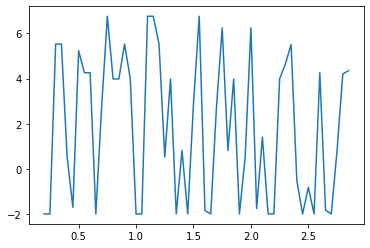

In [34]:
import matplotlib.pylab as plt

plt.plot(Rs, vals_perfect, label="perfect")
plt.plot(Rs, vals_trotter_4, label="p=4")
plt.plot(Rs, vals_trotter_10, label="p=10")
plt.legend()